## Boston 주택 가격 예측 모델

### 데이터 로드 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tf.keras.utils.set_random_seed(42)

In [2]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

print(len(train_data))
print(len(test_data))

404
102


In [3]:
mean = train_data.mean(axis=0)
train_data = train_data - mean

std = train_data.std(axis=0)
train_data = train_data / std

test_data = (test_data - mean) / std

In [4]:
model = models.Sequential([layers.Input(shape=(train_data.shape[1],)),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(1)])

model.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

In [5]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

history = model.fit(train_data, train_labels, epochs=200, batch_size=32, 
                    validation_split=0.2, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 96.
Epoch 116: early stopping


C:\Users\Administrator\AppData\Local\Temp;\ipykernel_8984\2661988120.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


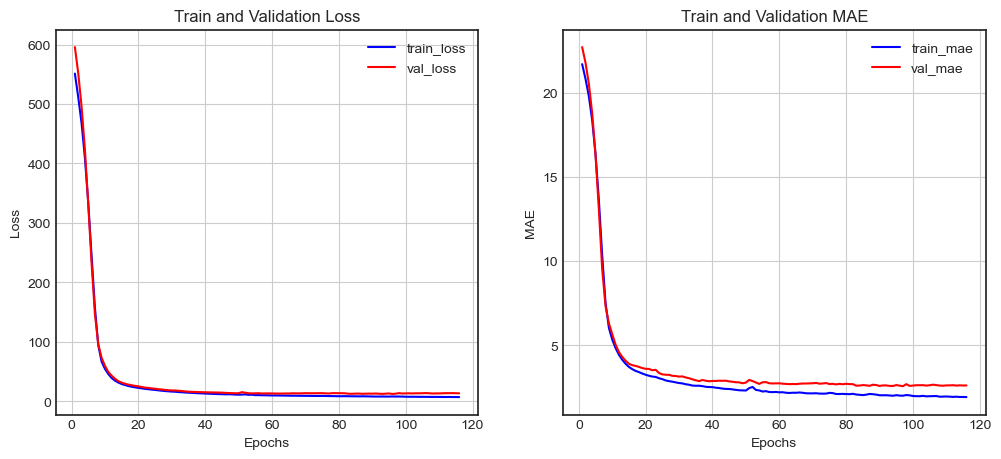

In [ ]:
plt.style.use('seaborn-white')

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

mae = history_dict['mae']
val_mae = history_dict['val_mae']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')
ax2.plot(epochs, val_mae, 'r-', label='val_mae')
ax2.set_title('Train and Validation MAE')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MAE')  
ax2.grid()
ax2.legend()

plt.show()

In [7]:
test_mse, test_mae = model.evaluate(test_data, test_labels, verbose=0)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

Test MSE: 24.3180, Test MAE: 3.1634


---
## 추가 실습

### 로그 변환(타깃) + kernel_initializer 추가 + 교차 검정

In [8]:
def ensure_2d(X, d=None):
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, d if d is not None else 1)
    return X

def build_reg(input_dim, units=64):
    m = models.Sequential([layers.Input(shape=(input_dim,)), 
                           layers.Dense(units, activation='relu', kernel_initializer='he_normal'),
                           layers.Dense(units, activation='relu', kernel_initializer='he_normal'),
                           layers.Dense(1)])
    m.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
    return m

def plot_cv_histories(histories):
    cmap = plt.get_cmap('tab10')
    fig, (ax_loss, ax_mae) = plt.subplots(1, 2, figsize=(12, 4))
    for i, H in enumerate(histories, 1):
        color = cmap((i-1) % 10)
        ax_loss.plot(H['loss'],     color=color, linestyle='-',  alpha=0.6, label=f'fold{i} train')
        ax_loss.plot(H['val_loss'], color=color, linestyle='--', alpha=0.9, label=f'fold{i} val')
        ax_mae .plot(H['mae'],      color=color, linestyle='-',  alpha=0.6, label=f'fold{i} train')
        ax_mae .plot(H['val_mae'],  color=color, linestyle='--', alpha=0.9, label=f'fold{i} val')
    ax_loss.set_title('Train & Validation Loss per Fold (log target)')
    ax_loss.set_xlabel('Epoch'); ax_loss.set_ylabel('Loss')
    ax_loss.grid(True, alpha=0.3); ax_loss.legend(ncol=2, fontsize=9)
    ax_mae.set_title('Train & Validation MAE per Fold (log target)')
    ax_mae.set_xlabel('Epoch'); ax_mae.set_ylabel('MAE')
    ax_mae.grid(True, alpha=0.3); ax_mae.legend(ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

def print_logtarget_test(model, X_test, y_test, prefix='[log-target]'):
    pred_log = model.predict(X_test, verbose=0).ravel()
    pred = np.expm1(pred_log)
    mse = np.mean((pred - y_test)**2)
    mae = np.mean(np.abs(pred - y_test))
    print(f"{prefix} Test MSE={mse:.3f}  MAE={mae:.3f}")
    return mse, mae

In [ ]:
(train_X, train_y), (test_X, test_y) = boston_housing.load_data()
train_X = ensure_2d(train_X, d=13); test_X = ensure_2d(test_X, d=13)
train_y = train_y.astype(np.float32).ravel(); test_y = test_y.astype(np.float32).ravel()

mean = train_X.mean(axis=0)
std = train_X.std(axis=0); std[std == 0] = 1.0
X_tr = (train_X - mean) / std
X_te = (test_X  - mean) / std

y_tr_log = np.log1p(train_y)
model = build_reg(input_dim=X_tr.shape[-1], units=64)

es = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
history = model.fit(X_tr, y_tr_log, validation_split=0.2, epochs=200, batch_size=32, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 103.
Epoch 123: early stopping


[Train] final loss=0.0053, mae=0.0526
[Valid] best  loss=0.0496 (epoch 103), mae@best=0.1740


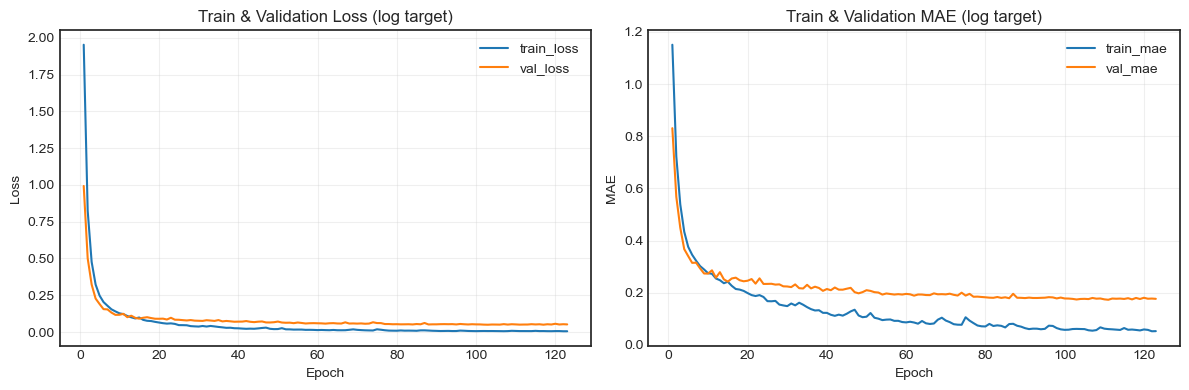

In [10]:
H = history.history
train_loss_last = H['loss'][-1]
train_mae_last  = H['mae'][-1]
best_idx = int(np.argmin(H['val_loss']))
best_val_loss = H['val_loss'][best_idx]
best_val_mae  = H['val_mae'][best_idx]
print(f"[Train] final loss={train_loss_last:.4f}, mae={train_mae_last:.4f}")
print(f"[Valid] best  loss={best_val_loss:.4f} (epoch {best_idx+1}), mae@best={best_val_mae:.4f}")

epochs = range(1, len(H['loss']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(epochs, H['loss'],     label='train_loss')
ax[0].plot(epochs, H['val_loss'], label='val_loss')
ax[0].set_title('Train & Validation Loss (log target)')
ax[0].set_xlabel('Epoch'); ax[0].set_ylabel('Loss')
ax[0].grid(True, alpha=0.3); ax[0].legend()
ax[1].plot(epochs, H['mae'],     label='train_mae')
ax[1].plot(epochs, H['val_mae'], label='val_mae')
ax[1].set_title('Train & Validation MAE (log target)')
ax[1].set_xlabel('Epoch'); ax[1].set_ylabel('MAE')
ax[1].grid(True, alpha=0.3); ax[1].legend()
plt.tight_layout(); plt.show()

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
histories = []
cv_mae, cv_rmse, cv_r2 = [], [], []

for fold, (tr_idx, va_idx) in enumerate(kf.split(train_X), 1):
    Xtr, Xva = train_X[tr_idx], train_X[va_idx]
    ytr, yva = train_y[tr_idx], train_y[va_idx]
    yva_orig = yva.copy()

    m_ = Xtr.mean(axis=0); s_ = Xtr.std(axis=0); s_[s_ == 0] = 1.0
    Xtr = (Xtr - m_) / s_;  Xva = (Xva - m_) / s_
    ytr = np.log1p(ytr); yva = np.log1p(yva)

    m = build_reg(input_dim=Xtr.shape[-1], units=64)
    h = m.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=300, batch_size=32, verbose=0,
              callbacks=[callbacks.EarlyStopping('val_loss', 20, restore_best_weights=True, verbose=0)])
    histories.append(h.history)

    yhat = np.expm1(m.predict(Xva, verbose=0).ravel())
    cv_mae.append(mean_absolute_error(yva_orig, yhat))
    cv_rmse.append(mean_squared_error(yva_orig, yhat, squared=False))
    cv_r2.append(r2_score(yva_orig, yhat))

print("=== CV Summary (original scale) ===")
print("MAE  mean±std : {:.3f} ± {:.3f}".format(np.mean(cv_mae), np.std(cv_mae)))
print("RMSE mean±std : {:.3f} ± {:.3f}".format(np.mean(cv_rmse), np.std(cv_rmse)))
print("R2   mean±std : {:.3f} ± {:.3f}".format(np.mean(cv_r2), np.std(cv_r2)))

=== CV Summary (original scale) ===
MAE  mean±std : 21.793 ± 3.979
RMSE mean±std : 39.279 ± 29.460
R2   mean±std : -24.046 ± 34.017


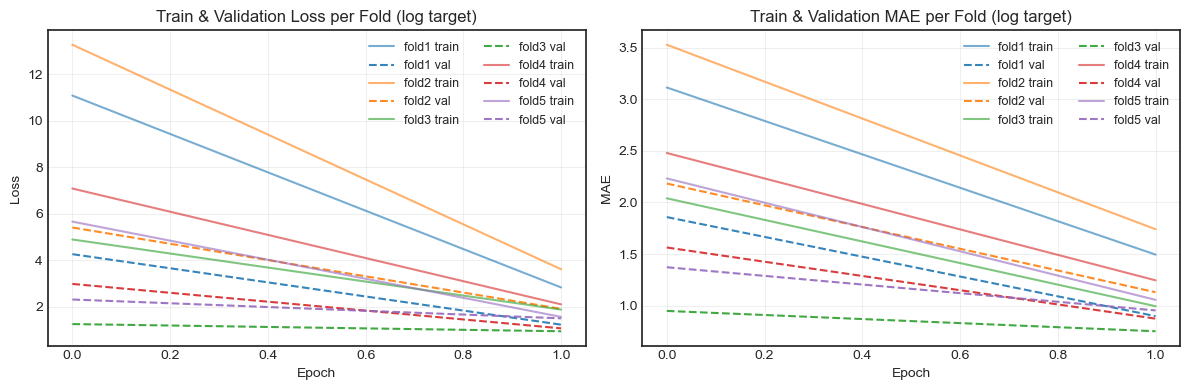

In [12]:
plot_cv_histories(histories)

In [ ]:
mean_all = train_X.mean(axis=0)
std_all  = train_X.std(axis=0); std_all[std_all == 0] = 1.0
X_tr_all = (train_X - mean_all) / std_all
X_te_all = (test_X  - mean_all) / std_all

final_model = build_reg(input_dim=X_tr_all.shape[-1], units=64)
final_es = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
_ = final_model.fit(X_tr_all, np.log1p(train_y), validation_split=0.1, epochs=300, batch_size=32,
                    callbacks=[final_es], verbose=0)

In [14]:
print_logtarget_test(final_model, X_te_all, test_y)

[log-target] Test MSE=76.712  MAE=5.072


(76.71194, 5.0721436)